In [1]:
import json

%cd /root

!mkdir .kaggle
data = {"username":"your usernamr","key":"your key"}        #change this based on your kaggle account
with open('.kaggle/kaggle.json', 'w') as f:
    json.dump(data, f)

!kaggle datasets download -d behrad3d/nasa-cmaps
!unzip nasa-cmaps.zip

/root
 73% 9.00M/12.3M [00:00<00:00, 18.2MB/s]
100% 12.3M/12.3M [00:00<00:00, 22.9MB/s]
Archive:  nasa-cmaps.zip
  inflating: CMaps/Damage Propagation Modeling.pdf  
  inflating: CMaps/RUL_FD001.txt     
  inflating: CMaps/RUL_FD002.txt     
  inflating: CMaps/RUL_FD003.txt     
  inflating: CMaps/RUL_FD004.txt     
  inflating: CMaps/readme.txt        
  inflating: CMaps/test_FD001.txt    
  inflating: CMaps/test_FD002.txt    
  inflating: CMaps/test_FD003.txt    
  inflating: CMaps/test_FD004.txt    
  inflating: CMaps/train_FD001.txt   
  inflating: CMaps/train_FD002.txt   
  inflating: CMaps/train_FD003.txt   
  inflating: CMaps/train_FD004.txt   
  inflating: CMaps/x.txt             


In [20]:

%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed, SimpleRNN

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
dir_path = '/root/CMaps/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
test.head(232)

(61249, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0          1            1    20.0072     0.7000      100.0  491.19  606.67   
1          1            2    24.9984     0.6200       60.0  462.54  536.22   
2          1            3    42.0000     0.8420      100.0  445.00  549.23   
3          1            4    42.0035     0.8402      100.0  445.00  549.19   
4          1            5    35.0079     0.8400      100.0  449.44  555.10   
..       ...          ...        ...        ...        ...     ...     ...   
227        1          228    42.0010     0.8418      100.0  445.00  549.45   
228        1          229    42.0055     0.8400      100.0  445.00  549.45   
229        1          230    25.0070     0.6214       60.0  462.54  537.66   
230        2            1    25.0041     0.6200       60.0  462.54  536.84   
231        2            2    25.0064     0.6200       60.0  462.54  536.72   

         s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  \
0    1481.04  1227.81  9.35  ...  313.03  2387.78  8048.98   9.2229  0.02   
1    1256.17  1031.48  7.05  ...  163.61  2028.09  7863.46  10.8632  0.02   
2    1340.13  1105.88  3.91  ...  129.98  2387.95  8071.13   9.3960  0.02   
3    1339.70  1107.26  3.91  ...  129.48  2387.90  8078.89   9.3594  0.02   
4    1353.04  1117.80  5.48  ...  181.82  2387.87  8057.83   9.3030  0.02   
..       ...      ...   ...  ...     ...      ...      ...      ...   ...   
227  1352.89  1129.70  3.91  ...  131.55  2388.40  8112.49   9.2161  0.02   
228  1356.32  1129.66  3.91  ...  131.49  2388.45  8109.04   9.2439  0.02   
229  1264.31  1046.41  7.05  ...  166.19  2028.53  7890.31  10.7615  0.02   
230  1264.01  1035.72  7.05  ...  165.16  2028.31  7874.79  10.8906  0.02   
231  1259.85  1046.62  7.05  ...  165.06  2028.28  7879.67  10.8786  0.02   

     s_17  s_18    s_19   s_20     s_21  
0     362  2324  100.00  24.31  14.7007  
1     306  1915   84.93  14.36   8.5748  
2     328  2212  100.00  10.39   6.4365  
3     328  2212  100.00  10.56   6.2367  
4     333  2223  100.00  14.85   8.9326  
..    ...   ...     ...    ...      ...  
227   332  2212  100.00  10.65   6.5274  
228   331  2212  100.00  10.54   6.3622  
229   308  1915   84.93  14.41   8.6329  
230   307  1915   84.93  14.31   8.4892  
231   306  1915   84.93  14.23   8.6502  

[232 rows x 26 columns]

In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head(1000)
print(train.shape)

(61249, 27)


In [5]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()
X_train.head(20)

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0     42.0049     0.8400      100.0  445.00  549.68  1343.43  1112.93   3.91   
1     20.0020     0.7002      100.0  491.19  606.07  1477.61  1237.50   9.35   
2     42.0038     0.8409      100.0  445.00  548.95  1343.12  1117.05   3.91   
3     42.0000     0.8400      100.0  445.00  548.70  1341.24  1118.03   3.91   
4     25.0063     0.6207       60.0  462.54  536.10  1255.23  1033.59   7.05   
5     34.9996     0.8400      100.0  449.44  554.77  1352.87  1117.01   5.48   
6      0.0019     0.0001      100.0  518.67  641.83  1583.47  1393.89  14.62   
7     41.9981     0.8400      100.0  445.00  549.05  1344.16  1110.77   3.91   
8     42.0016     0.8400      100.0  445.00  549.55  1342.85  1101.67   3.91   
9     25.0019     0.6217       60.0  462.54  536.35  1251.91  1041.37   7.05   
10    20.0016     0.7000      100.0  491.19  606.88  1478.02  1233.07   9.35   
11    34.9993     0.8400      100.0  449.44  554.53  1365.99  1122.73   5.48   
12    24.9986     0.6200       60.0  462.54  536.32  1257.84  1040.87   7.05   
13    20.0056     0.7008      100.0  491.19  607.32  1470.33  1242.41   9.35   
14    25.0000     0.6200       60.0  462.54  536.12  1259.02  1037.54   7.05   
15    20.0006     0.7012      100.0  491.19  606.15  1473.82  1246.43   9.35   
16     9.9989     0.2506      100.0  489.05  603.80  1484.62  1293.36  10.52   
17    42.0018     0.8400      100.0  445.00  549.42  1344.69  1113.86   3.91   
18    20.0031     0.7000      100.0  491.19  606.65  1472.33  1237.74   9.35   
19    20.0070     0.7014      100.0  491.19  606.46  1477.29  1235.14   9.35   

      s_6     s_7  ...    s_12     s_13     s_14     s_15  s_16  s_17  s_18  \
0    5.70  137.36  ...  129.78  2387.99  8074.83   9.3335  0.02   330  2212   
1   13.61  332.10  ...  312.59  2387.73  8046.13   9.1913  0.02   361  2324   
2    5.69  138.18  ...  129.62  2387.97  8066.62   9.4007  0.02   329  2212   
3    5.70  137.98  ...  129.80  2388.02  8076.05   9.3369  0.02   328  2212   
4    9.00  174.82  ...  164.11  2028.08  7865.80  10.8366  0.02   305  1915   
5    7.97  193.82  ...  181.90  2387.87  8054.10   9.3346  0.02   330  2223   
6   21.58  552.45  ...  520.48  2387.89  8127.92   8.3960  0.03   391  2388   
7    5.69  137.13  ...  129.65  2387.97  8075.99   9.3679  0.02   329  2212   
8    5.70  138.02  ...  129.65  2388.00  8071.13   9.3384  0.02   328  2212   
9    9.01  174.70  ...  164.08  2028.13  7869.41  10.9141  0.02   305  1915   
10  13.61  333.22  ...  312.96  2387.83  8050.06   9.1667  0.02   363  2324   
11   7.98  193.67  ...  181.71  2387.86  8056.31   9.3041  0.02   332  2223   
12   9.01  174.53  ...  163.67  2028.14  7865.15  10.8388  0.02   305  1915   
13  13.61  333.71  ...  313.30  2387.85  8051.34   9.2272  0.02   364  2324   
14   9.01  174.83  ...  163.43  2028.11  7863.73  10.9008  0.02   304  1915   
15  13.61  333.02  ...  312.96  2387.86  8050.95   9.1945  0.02   361  2324   
16  15.46  392.76  ...  369.56  2387.87  8122.63   8.6511  0.03   368  2319   
17   5.70  137.42  ...  130.18  2387.98  8079.03   9.3470  0.02   329  2212   
18  13.61  332.99  ...  312.78  2387.80  8052.35   9.2416  0.02   363  2324   
19  13.61  333.53  ...  313.34  2387.78  8053.73   9.1905  0.02   363  2324   

      s_19   s_20     s_21  
0   100.00  10.62   6.3670  
1   100.00  24.37  14.6552  
2   100.00  10.48   6.4213  
3   100.00  10.54   6.4176  
4    84.93  14.03   8.6754  
5   100.00  14.91   8.9057  
6   100.00  38.93  23.4578  
7   100.00  10.55   6.2787  
8   100.00  10.63   6.3055  
9    84.93  14.34   8.6119  
10  100.00  24.63  14.6705  
11  100.00  14.68   8.8752  
12   84.93  14.41   8.6062  
13  100.00  24.30  14.7105  
14   84.93  14.27   8.5551  
15  100.00  24.54  14.6804  
16  100.00  28.45  17.1975  
17  100.00  10.62   6.3735  
18  100.00  24.14  14.6014  
19  100.00  24.37  14.6054  

[20 rows x 24 columns]

In [6]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Linear regression

In [7]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:60.285995553435896, R2:0.5491334954684775
test set RMSE:47.757648328701606, R2:0.23279090539902436


# MLP

In [56]:
from sklearn.model_selection import GroupShuffleSplit

# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  18  21  22  23  24  27
  28  29  30  32  33  35  36  37  38  40  41  42  43  44  45  47  48  49
  50  51  52  53  54  55  57  58  59  60  62  63  64  65  66  67  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  99 100 101 102 103 104 106 107 108 110 111 114
 116 117 118 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 139 140 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 161 162 164 165 166 167 168 169 170 171 172 175 177 178 179
 180 182 183 186 187 188 189 190 192 193 198 199 203 204 205 206 207 208
 209 210 211 212 213 214 215 217 218 219 220 221 222 223 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 241 242 243 244 245 246 248
 249] 

validate_split_engines [  7  10  11  16  17  19  20  25  26  31  34  39  46  56  61  68  69  70
  97  98 105 109 112 113 115 119 121 138 141 159 160 163 173 174 176 181


In [57]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)
# set index because unit_nr begins at 1 instead of 0

In [58]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  18  21  22  23  24  27
  28  29  30  32  33  35  36  37  38  40  41  42  43  44  45  47  48  49
  50  51  52  53  54  55  57  58  59  60  62  63  64  65  66  67  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  99 100 101 102 103 104 106 107 108 110 111 114
 116 117 118 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 139 140 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 161 162 164 165 166 167 168 169 170 171 172 175 177 178 179
 180 182 183 186 187 188 189 190 192 193 198 199 203 204 205 206 207 208
 209 210 211 212 213 214 215 217 218 219 220 221 222 223 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 241 242 243 244 245 246 248
 249] 

validate_split_engines [  7  10  11  16  17  19  20  25  26  31  34  39  46  56  61  68  69  70
  97  98 105 109 112 113 115 119 121 138 141 159 160 163 173 174 176 181


In [59]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
epochs = 100

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/20
1541/1541 [==============================] - 6s 4ms/step - loss: 1968.9916 - val_loss: 1695.0959
Epoch 2/20
1541/1541 [==============================] - 5s 3ms/step - loss: 1606.4619 - val_loss: 1593.6848
Epoch 3/20
1541/1541 [==============================] - 4s 3ms/step - loss: 1542.0735 - val_loss: 1497.8204
Epoch 4/20
1541/1541 [==============================] - 4s 3ms/step - loss: 1393.3708 - val_loss: 1286.9460
Epoch 5/20
1541/1541 [==============================] - 4s 3ms/step - loss: 1115.7770 - val_loss: 1033.4705
Epoch 6/20
1541/1541 [==============================] - 5s 3ms/step - loss: 864.1213 - val_loss: 916.4123
Epoch 7/20
1541/1541 [==============================] - 5s 3ms/step - loss: 766.1411 - val_loss: 858.1585
Epoch 8/20
1541/1541 [==============================] - 4s 3ms/step - loss: 737.2277 - val_loss: 751.1680
Epoch 9/20
1541/1541 [==============================] - 4s 3ms/step - loss: 713.6584 - val_loss: 751.7703
Epoch 10/20
1541/1541 [=============

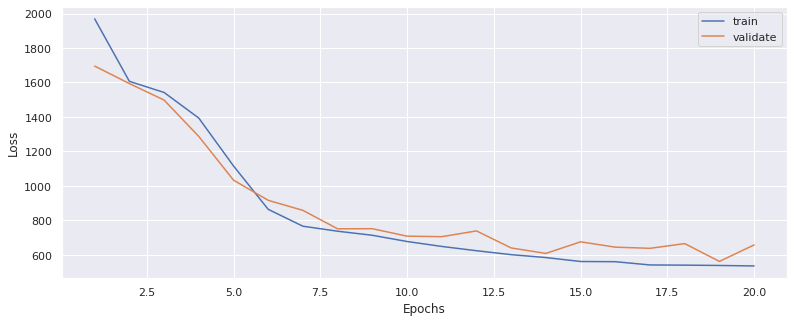

In [61]:
plot_loss(history)

In [62]:
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_scaled[train_cols])
evaluate(y_test, y_hat_test)

1915/1915 [==============================] - 3s 1ms/step
train set RMSE:23.631672990160833, R2:0.6622836561028329
8/8 [==============================] - 0s 2ms/step
test set RMSE:37.346000462446696, R2:0.5308452989281849


In [8]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test
  
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)
# print(X_train_condition_scaled)

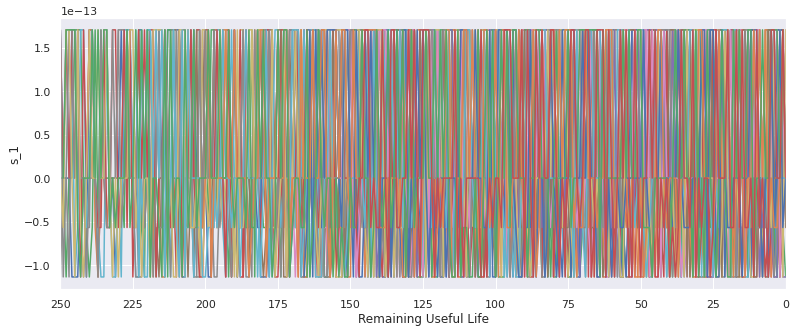

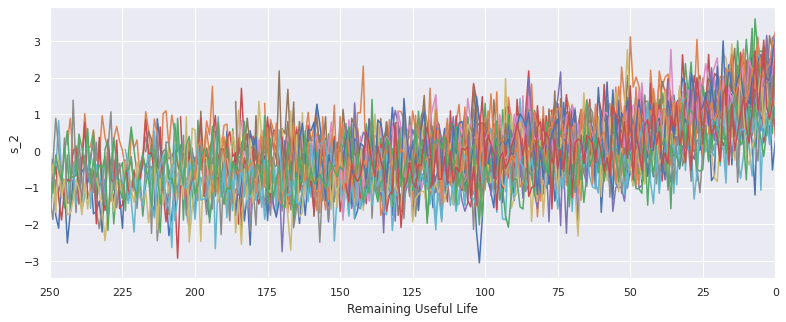

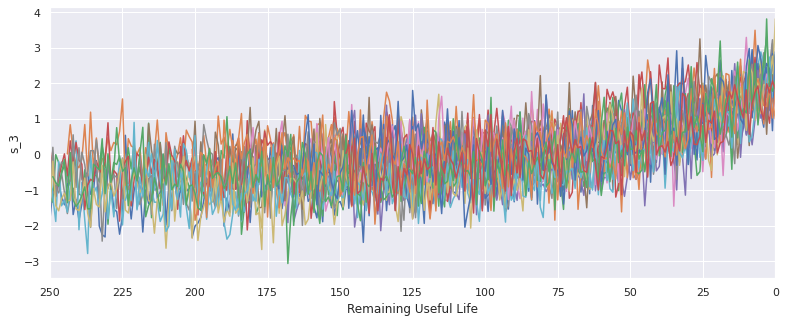

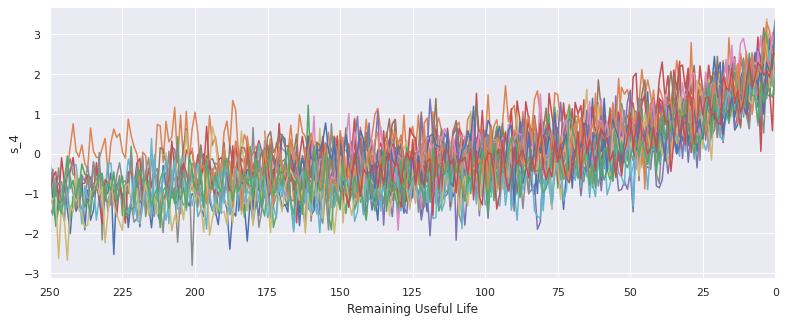

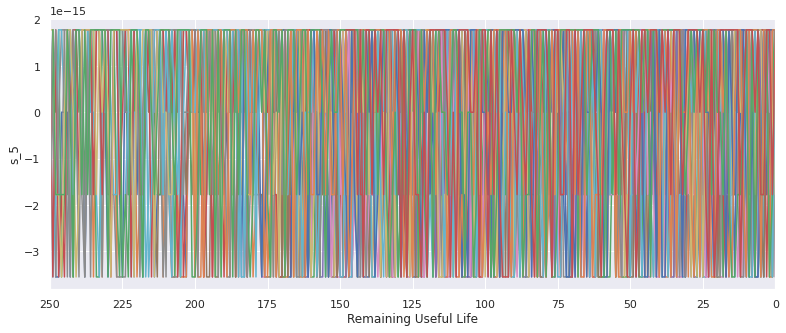

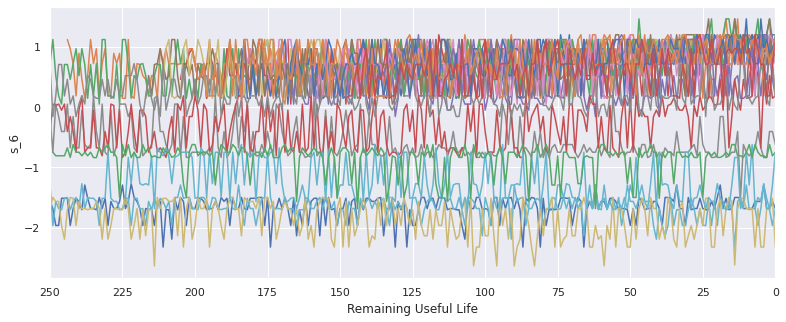

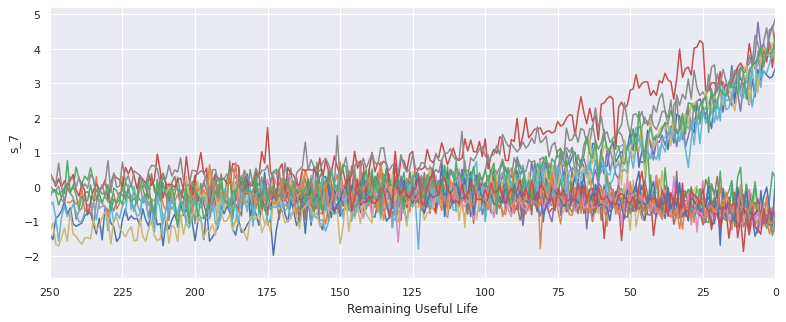

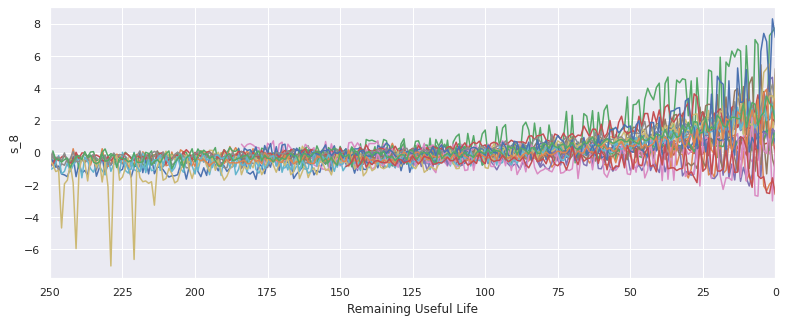

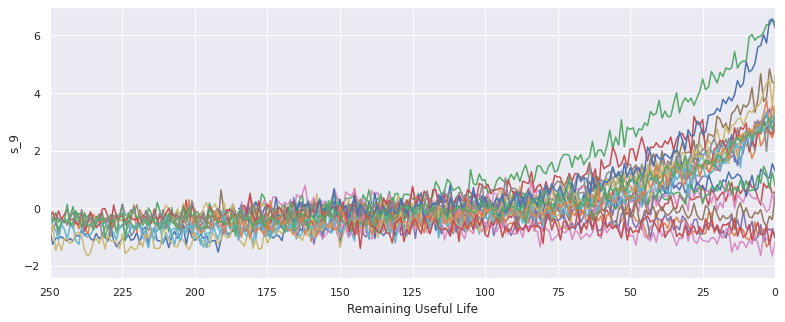

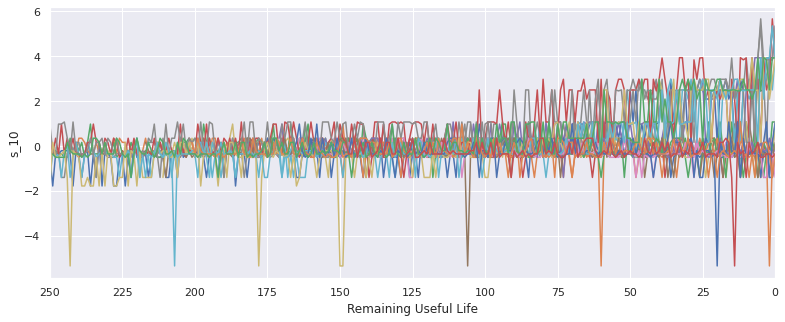

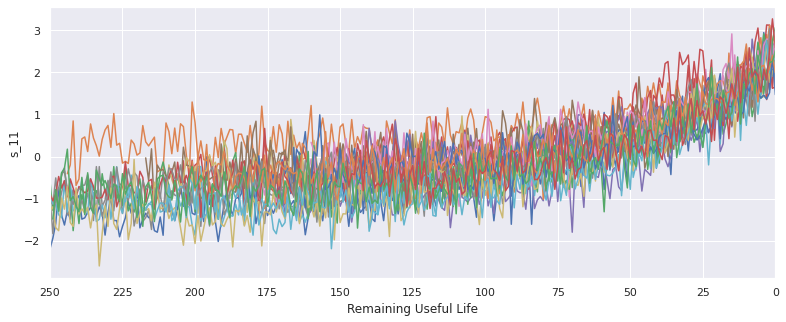

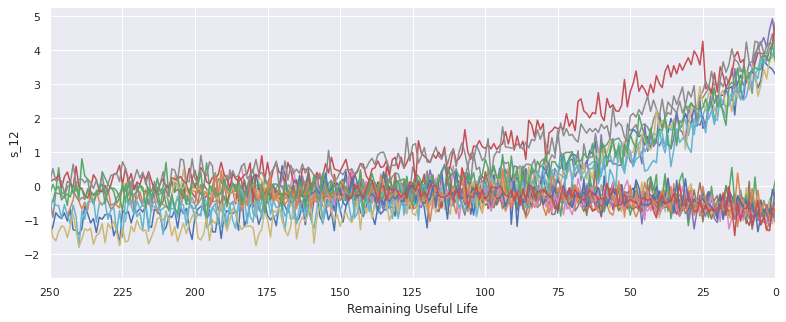

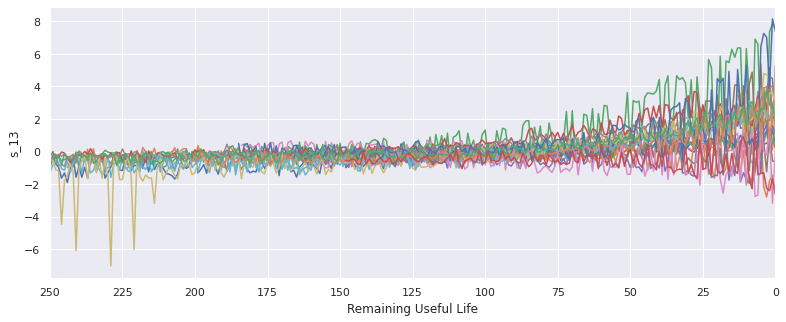

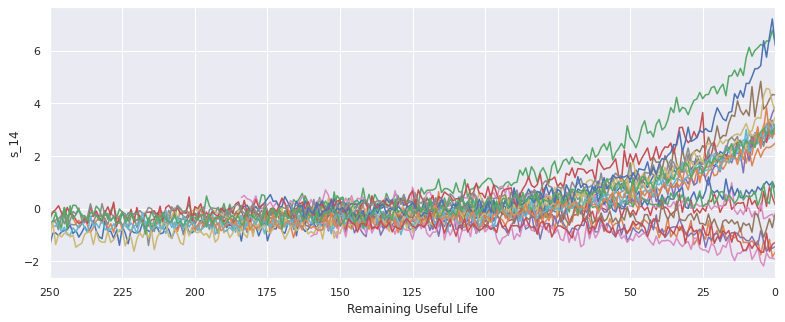

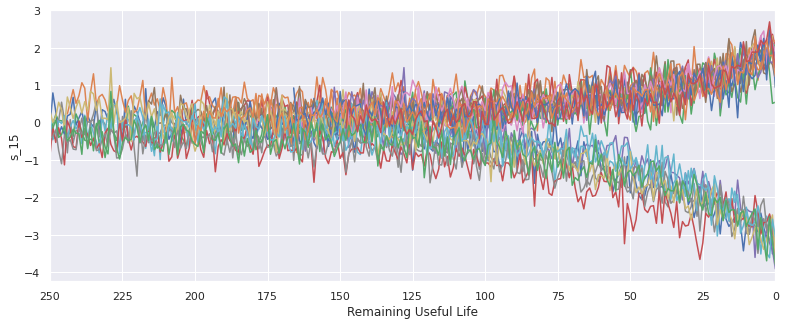

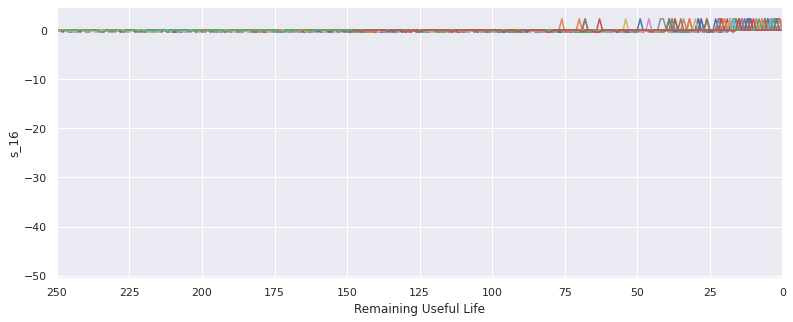

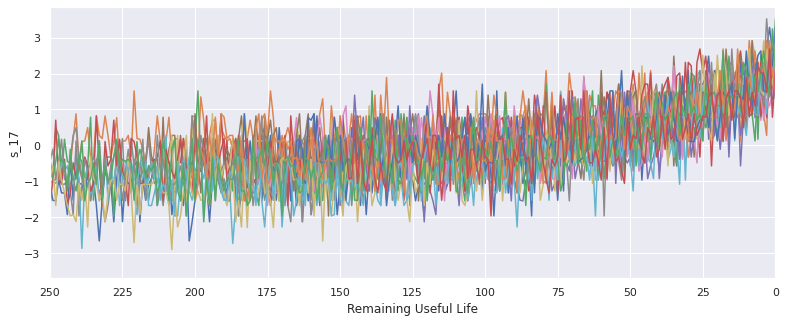

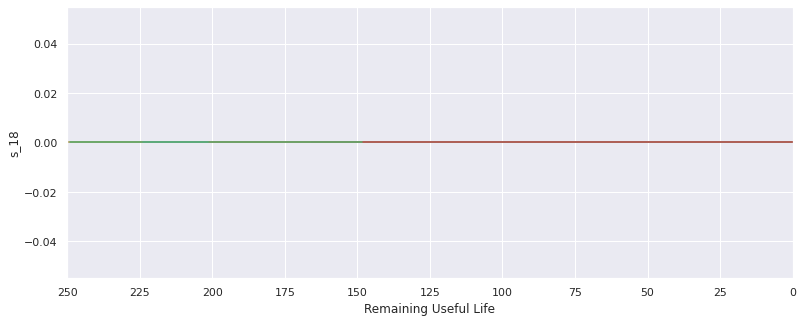

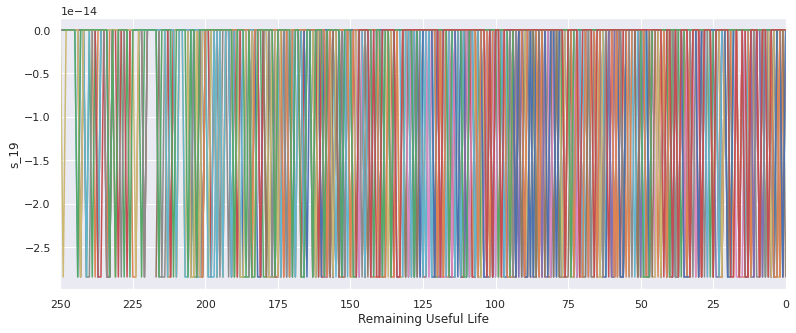

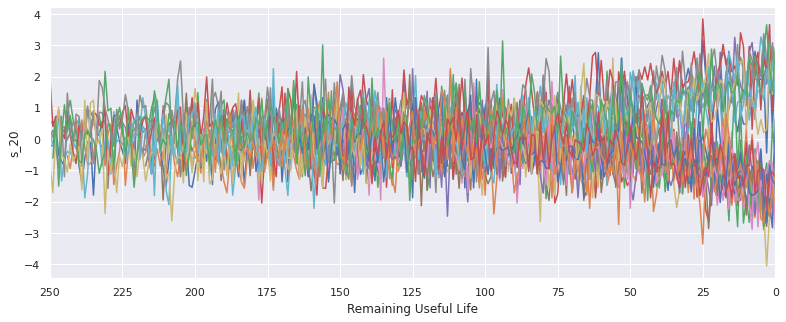

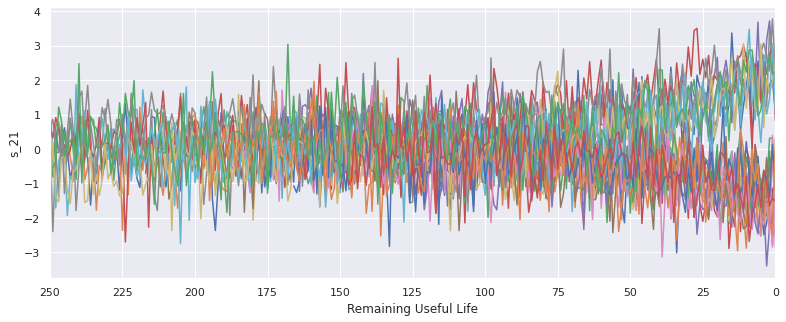

In [9]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()
    
for sensor in sensor_names:
  plot_signal(X_train_condition_scaled, sensor)

In [10]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [64]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [12]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

In [13]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


In [14]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [15]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [16]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [65]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

# RNN

In [22]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1423/1423 [==============================] - 48s 33ms/step - loss: 5728.9863 - val_loss: 3111.4082
Epoch 2/20
1423/1423 [==============================] - 44s 31ms/step - loss: 2901.0850 - val_loss: 1205.7340
Epoch 3/20
1423/1423 [==============================] - 44s 31ms/step - loss: 745.6758 - val_loss: 554.2130
Epoch 4/20
1423/1423 [==============================] - 39s 27ms/step - loss: 382.9713 - val_loss: 461.5381
Epoch 5/20
1423/1423 [==============================] - 38s 27ms/step - loss: 321.9609 - val_loss: 440.6278
Epoch 6/20
1423/1423 [==============================] - 37s 26ms/step - loss: 308.3863 - val_loss: 474.2489
Epoch 7/20
1423/1423 [==============================] - 41s 29ms/step - loss: 300.5542 - val_loss: 434.1679
Epoch 8/20
1423/1423 [==============================] - 36s 25ms/step - loss: 335.1871 - val_loss: 438.0905
Epoch 9/20
1423/1423 [==============================] - 44s 31ms/step - loss: 292.4819 - val_loss: 426.3410
Epoch 10/20
1423/1423 [=

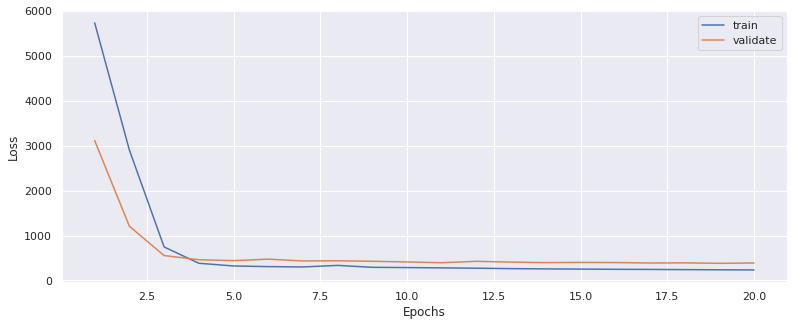

In [25]:
plot_loss(history)

In [26]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 [==============================] - 6s 4ms/step
train set RMSE:16.135852813720703, R2:0.846788214455886
8/8 [==============================] - 0s 4ms/step
test set RMSE:28.658540887869105, R2:0.723728537882655


# LSTM

In [49]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [50]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1423/1423 [==============================] - 15s 8ms/step - loss: 5471.7871 - val_loss: 3096.1392
Epoch 2/20
1423/1423 [==============================] - 10s 7ms/step - loss: 1965.9780 - val_loss: 1129.7932
Epoch 3/20
1423/1423 [==============================] - 10s 7ms/step - loss: 679.5796 - val_loss: 500.3577
Epoch 4/20
1423/1423 [==============================] - 10s 7ms/step - loss: 307.1459 - val_loss: 397.9916
Epoch 5/20
1423/1423 [==============================] - 10s 7ms/step - loss: 234.3039 - val_loss: 357.2212
Epoch 6/20
1423/1423 [==============================] - 10s 7ms/step - loss: 215.6317 - val_loss: 361.5404
Epoch 7/20
1423/1423 [==============================] - 10s 7ms/step - loss: 209.1743 - val_loss: 350.7397
Epoch 8/20
1423/1423 [==============================] - 10s 7ms/step - loss: 203.3096 - val_loss: 377.3296
Epoch 9/20
1423/1423 [==============================] - 10s 7ms/step - loss: 201.4274 - val_loss: 349.5490
Epoch 10/20
1423/1423 [==========

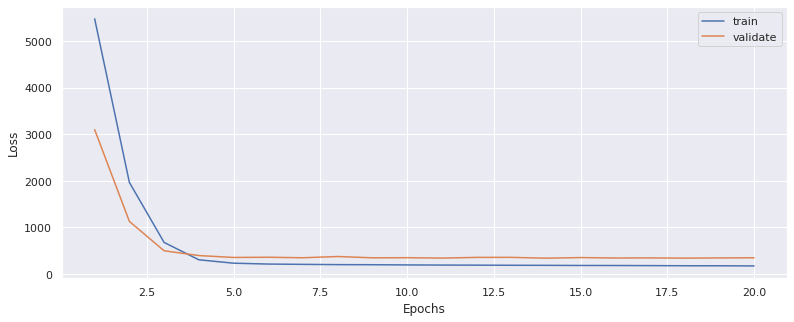

In [51]:
plot_loss(history)

In [52]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 [==============================] - 6s 3ms/step
train set RMSE:14.361403465270996, R2:0.878632602678943
8/8 [==============================] - 0s 4ms/step
test set RMSE:27.112168676054694, R2:0.752738561528975


## Threshold

In [47]:
def accuracy(y, y_hat, thresh):
  TP = 0
  for i in range(y.shape[0]):
    if abs(y_hat[i] - y['RemainingUsefulLife'][i])<=thresh:
      TP+=1 
  return round(TP/ len(y)*100,2)

In [54]:
# def accuracy_pos(y, y_hat, thresh):
#   TP = 0
#   for i in range(y.shape[0]):
#     if (y_hat[i] - y['RemainingUsefulLife'][i])<=thresh and (y_hat[i] - y['RemainingUsefulLife'][i])>=0:
#       TP+=1 
#   return round(TP/ len(y)*100,2)

In [53]:
for i in range(10,101,5):
  print(f'for thresh {i} : {accuracy(y_test, y_hat_test,i)}')

for thresh 10 : 40.73
for thresh 15 : 54.44
for thresh 20 : 60.89
for thresh 25 : 67.34
for thresh 30 : 72.58
for thresh 35 : 77.82
for thresh 40 : 83.87
for thresh 45 : 88.31
for thresh 50 : 91.13
for thresh 55 : 92.74
for thresh 60 : 96.37
for thresh 65 : 96.77
for thresh 70 : 98.79
for thresh 75 : 100.0
for thresh 80 : 100.0
for thresh 85 : 100.0
for thresh 90 : 100.0
for thresh 95 : 100.0
for thresh 100 : 100.0


## LSTM with dropped sensors 

In [63]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
       's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [66]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('simple_lstm_weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1423/1423 [==============================] - 16s 9ms/step - loss: 5563.5024 - val_loss: 3088.2043
Epoch 2/20
1423/1423 [==============================] - 11s 8ms/step - loss: 1952.6489 - val_loss: 1117.5648
Epoch 3/20
1423/1423 [==============================] - 13s 9ms/step - loss: 704.9273 - val_loss: 552.8810
Epoch 4/20
1423/1423 [==============================] - 13s 9ms/step - loss: 363.9942 - val_loss: 422.4848
Epoch 5/20
1423/1423 [==============================] - 11s 8ms/step - loss: 286.9945 - val_loss: 390.7729
Epoch 6/20
1423/1423 [==============================] - 10s 7ms/step - loss: 266.9803 - val_loss: 378.8868
Epoch 7/20
 586/1423 [===========>..................] - ETA: 5s - loss: 257.3090

In [ ]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 [==============================] - 14s 7ms/step
train set RMSE:13.18301010131836, R2:0.8977325311915734
8/8 [==============================] - 0s 9ms/step
test set RMSE:27.456361238051752, R2:0.7464206780649496


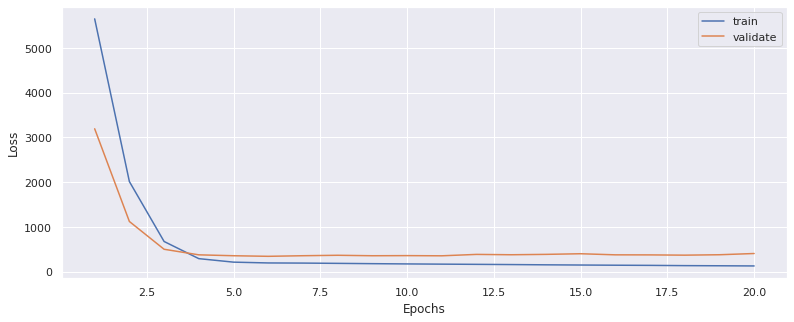

In [ ]:
plot_loss(history)

# Hyperparameter Tuning

In [ ]:
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

100352

In [ ]:
def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_test_interim

In [ ]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [ ]:
ITERATIONS = 60

results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter_weights.h5'


for i in range(ITERATIONS):
    print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)


In [ ]:
results.head()

#Train Data

In [ ]:
train[index_names].describe()
train[index_names].groupby('unit_nr').max().describe()

In [ ]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

###Plot

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(y_test.reshape(-1))
plt.plot( y_hat_test)
plt.show()